In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError,Huber,MeanAbsoluteError
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.metrics import RootMeanSquaredError
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Data Preparation

input supervised data set

In [2]:
data=pd.read_csv("train.csv")
data.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


visualize relationship between data

In [3]:
#sns.pairplot(data[["v.id","on road old","on road now","years","km","rating","condition","economy","top speed","hp","torque","current price"]],diag_kind="kde")

prepare input tensors and output tensor

In [4]:
tf_data=tf.constant(data)
tf.cast(tf_data,tf.float32)
tf_data=tf.random.shuffle(tf_data)
x=tf_data[:,3:-1]
y=tf_data[:,-1]
y=tf.expand_dims(y,axis=-1)

prepare training,validation and training datasets

In [5]:
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1
DATASET_SIZE=len(x)

train dataset

In [6]:
x_train=x[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train=y[:int(DATASET_SIZE*TRAIN_RATIO)]

In [7]:
train_dataset= tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_dataset= train_dataset.shuffle(buffer_size=8,
                                     reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

validation dataset

In [8]:
x_val=x[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val=y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]

In [9]:
val_dataset= tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset= train_dataset.shuffle(buffer_size=8,
                                     reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

test dataset

In [10]:
x_test=x[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test=y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]

In [11]:
test_dataset= tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_dataset= train_dataset.shuffle(buffer_size=8,
                                     reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

transform input tensor (normalizaion)

In [12]:
normalizer= Normalization()
normalizer.adapt(x_train)
normalizer(x)

<tf.Tensor: shape=(1000, 8), dtype=float32, numpy=
array([[-0.33886552, -1.3778712 ,  1.4929838 , ...,  0.04437039,
         1.0821122 , -0.39018914],
       [ 1.3989078 , -0.10241438,  0.76735365, ...,  0.4565256 ,
         1.6189283 , -1.3444887 ],
       [ 1.3989078 , -1.2186762 ,  0.76735365, ...,  0.9717196 ,
         0.15488414,  1.2321202 ],
       ...,
       [-1.497381  ,  0.54654217,  0.76735365, ..., -0.6253818 ,
        -1.6507704 ,  0.7549704 ],
       [ 0.24039222, -0.28416914,  1.4929838 , ...,  1.1262778 ,
        -0.1379247 , -1.6784936 ],
       [ 0.81965   ,  0.16840675, -0.68390673, ...,  0.4565256 ,
        -0.7235424 ,  1.61384   ]], dtype=float32)>

creat model

In [13]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(8,)),
    normalizer,
    Dense(128,activation="relu"),
    Dense(128,activation="relu"),
    Dense(128,activation="relu"),
    Dense(1),
])

model summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,322
Trainable params: 34,305
Non-trainable params: 17
___________________________________________________

model structure

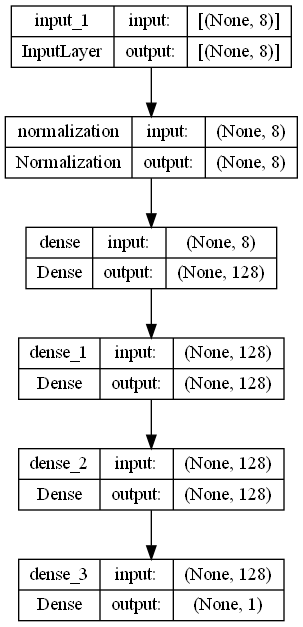

In [15]:
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True)

compile model and error management

In [16]:
model.compile(optimizer= Adam(learning_rate=0.1),
              loss=Huber(),
            metrics=RootMeanSquaredError())

# Train model

train model

In [17]:
history=model.fit(train_dataset,
                  validation_data=val_dataset,
                  epochs=100,
                  verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 17ms/step - loss: 152826.0156 - root_mean_squared_error: 203526.7344 - val_loss: 71438.1406 - val_root_mean_squared_error: 84247.7109
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 52060.2148 - root_mean_squared_error: 63873.0273 - val_loss: 46696.5391 - val_root_mean_squared_error: 56960.1016
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 44557.5234 - root_mean_squared_error: 55177.5078 - val_loss: 40186.3242 - val_root_mean_squared_error: 49736.0430
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 40006.2305 - root_mean_squared_error: 49919.3906 - val_loss: 39778.0508 - val_root_mean_squared_error: 49198.6016
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 44924.1289 - root_mean_squared_error: 55359.6641 - val_loss: 39395.3398 - val_root_mean_squared_error: 49248.9570
Epoch 6/100
25/25 [==============================] - 0s 2ms/st

25/25 [==============================] - 0s 2ms/step - loss: 35876.2930 - root_mean_squared_error: 44614.8398 - val_loss: 39787.9453 - val_root_mean_squared_error: 49136.3008
Epoch 43/100
25/25 [==============================] - 0s 2ms/step - loss: 35862.1914 - root_mean_squared_error: 44903.5586 - val_loss: 33798.3281 - val_root_mean_squared_error: 42481.6836
Epoch 44/100
25/25 [==============================] - 0s 2ms/step - loss: 36678.9219 - root_mean_squared_error: 45896.7969 - val_loss: 36088.4844 - val_root_mean_squared_error: 44954.4414
Epoch 45/100
25/25 [==============================] - 0s 2ms/step - loss: 36783.1016 - root_mean_squared_error: 46137.8477 - val_loss: 33971.4648 - val_root_mean_squared_error: 42673.2930
Epoch 46/100
25/25 [==============================] - 0s 2ms/step - loss: 35325.1367 - root_mean_squared_error: 43979.4844 - val_loss: 34069.0000 - val_root_mean_squared_error: 42616.9961
Epoch 47/100
25/25 [==============================] - 0s 2ms/step - loss:

Epoch 86/100
25/25 [==============================] - 0s 2ms/step - loss: 34400.4727 - root_mean_squared_error: 43899.0820 - val_loss: 32198.3984 - val_root_mean_squared_error: 40863.2266
Epoch 87/100
25/25 [==============================] - 0s 2ms/step - loss: 34158.9219 - root_mean_squared_error: 43927.2500 - val_loss: 34775.6016 - val_root_mean_squared_error: 43779.8633
Epoch 88/100
25/25 [==============================] - 0s 2ms/step - loss: 33898.4805 - root_mean_squared_error: 43191.0391 - val_loss: 33423.7344 - val_root_mean_squared_error: 42227.8984
Epoch 89/100
25/25 [==============================] - 0s 2ms/step - loss: 33549.1016 - root_mean_squared_error: 42806.4453 - val_loss: 34002.4922 - val_root_mean_squared_error: 42812.8242
Epoch 90/100
25/25 [==============================] - 0s 3ms/step - loss: 34409.0117 - root_mean_squared_error: 44553.1367 - val_loss: 32567.8145 - val_root_mean_squared_error: 41356.5273
Epoch 91/100
25/25 [==============================] - 0s 2ms

plotting loss

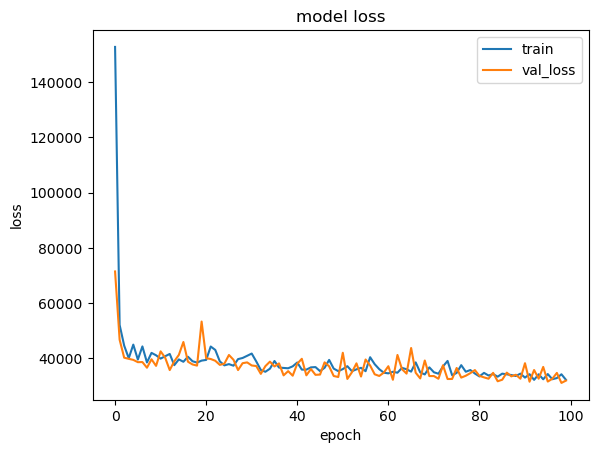

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()

# Preformance Measure

plotting RootMeanSquredError

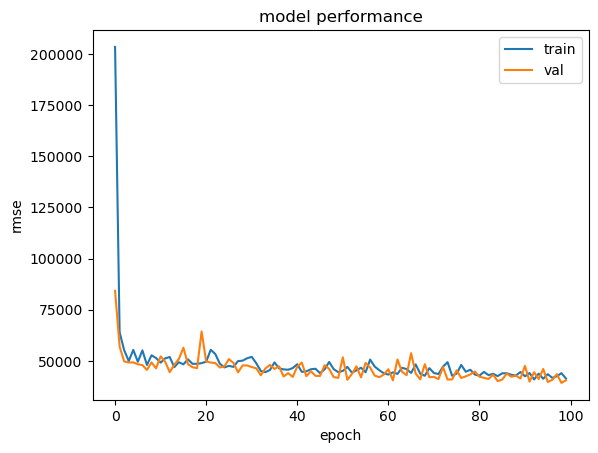

In [19]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.show()

# Validation

evaluate model

In [20]:
model.evaluate(x_val,y_val)

4/4 [==============================] - 0s 7ms/step - loss: 40602.8828 - root_mean_squared_error: 46559.5703


[40602.8828125, 46559.5703125]

evaluation test data

In [21]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 4ms/step - loss: 38958.1016 - root_mean_squared_error: 48697.6406


[38958.1015625, 48697.640625]

# Testing

testing for all test data

In [22]:
#model.predict(x_test)

test for one input

In [23]:
#model.predict(tf.expand_dims(x_test[1],axis=0)) #predicted price

In [24]:
#y_test[1].numpy() #actual price

testing for test dataset

In [25]:
y_true=list(y_test[:,0])
y_pred=list(model.predict(x_test)[:,0])

4/4 [==============================] - 0s 2ms/step


visualize perfromance

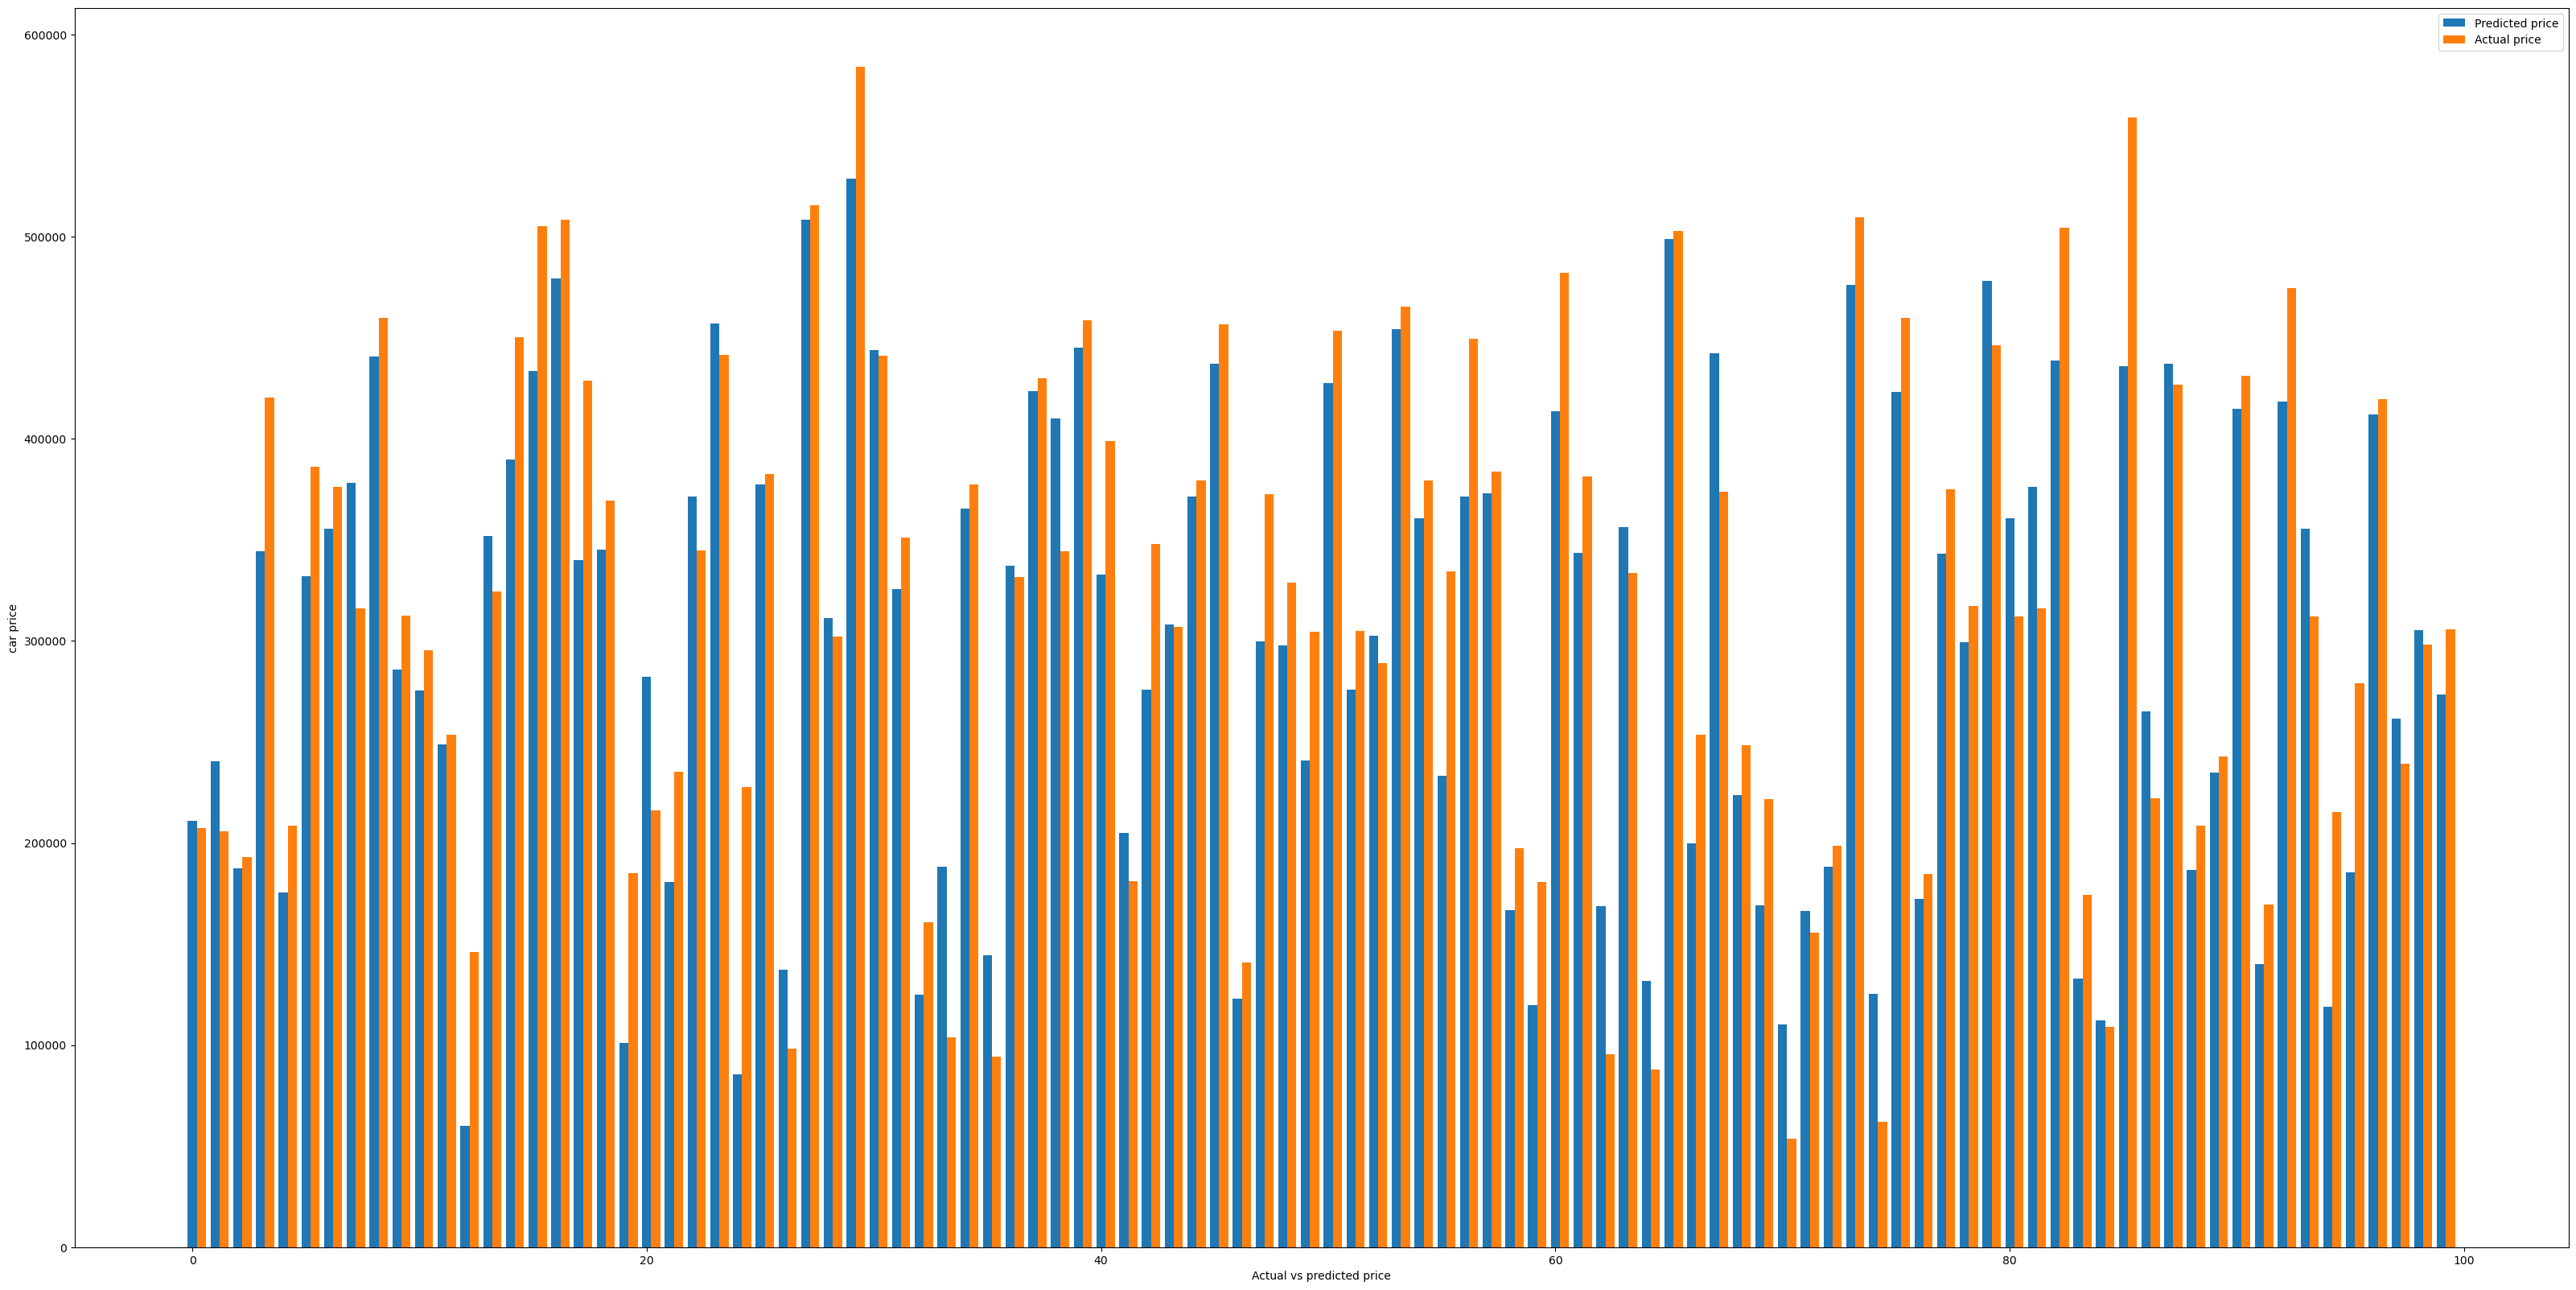

In [26]:
ind=np.arange(100)
plt.figure(figsize=(40,20))

width=0.4

plt.bar(ind,y_pred,width,label="predicted car price")
plt.bar(ind+width,y_true,width,label="Actual car price")

plt.xlabel("Actual vs predicted price")
plt.ylabel("car price")

plt.legend(['Predicted price','Actual price'])
plt.show()

save model

In [27]:
model.save("trained_car_price_model_save_1.hs")

INFO:tensorflow:Assets written to: trained_car_price_model_save_1.hs\assets


# Explain how it work

minimum diffrent

In [28]:
min_diffrent=50000
u=0
for x in range(0,100) :
    diffrent_value=abs(float(y_true[x]-y_pred[x]))
    if min_diffrent > diffrent_value :
        min_diffrent = diffrent_value
        u=x
print("predicted value=",y_pred[u])
print("true value=",y_true[u].numpy())
print(min_diffrent)
print("bar number = ",u)

predicted value= 308189.38
true value= 307008.0
1181.375
bar number =  43


In [29]:
print(f" year= {int(x_test[u,0])}\n km= {x_test[u,1]}\n rating= {int(x_test[u,2])}\n condition= {int(x_test[u,3])}\n economy= {int(x_test[u,4])}\n hp= {x_test[u,5]}\n torque= {x_test[u,6]}")

 year= 2
 km= 118272.0
 rating= 4
 condition= 10
 economy= 9
 hp= 152.0
 torque= 118.0


maximun diffrent

In [30]:
max_diffrent=0
u=0
for x in range(0,100) :
    diffrent_value=abs(float(y_true[x]-y_pred[x]))
    if max_diffrent < diffrent_value :
        max_diffrent = diffrent_value
        u=x
print("predicted value=",y_pred[u])
print("true value=",y_true[u].numpy())
print(max_diffrent)
print("bar number = ",u)

predicted value= 85330.664
true value= 227669.0
142338.3359375
bar number =  24


In [31]:
print(f" year= {int(x_test[u,0])}\n km= {x_test[u,1]}\n rating= {int(x_test[u,2])}\n condition= {int(x_test[u,3])}\n economy= {int(x_test[u,4])}\n hp= {x_test[u,5]}\n torque= {x_test[u,6]}")

 year= 4
 km= 139859.0
 rating= 3
 condition= 6
 economy= 14
 hp= 188.0
 torque= 54.0


summary

In [32]:
count_1=0
count_2=0
for x in range(0,100) :
    diffrent_value=abs(float(y_true[x]-y_pred[x]))
    if 5000 > diffrent_value :
        count_1+=1
    if 10000 < diffrent_value :
        count_2+=1
print("very success in = ",count_1,"    ratio =  ",float(count_1/10),"%")
print("normal          = ",1000-(count_1+count_2),"   ratio = ",float((1000-(count_1+count_2))/10),"%")
print("very bad        = ",count_2,"    ratio =  ",float(count_2/10),"%")

very success in =  7     ratio =   0.7 %
normal          =  909    ratio =  90.9 %
very bad        =  84     ratio =   8.4 %
